# 📘 实验：从样本空间到随机变量 —— 用 Python 理解概率与分布（基于掷两枚骰子）

> - 样本空间  
> - 事件与概率  
> - 加法法则（sum rule）  
> - 乘法法则（product rule）  
> - 随机变量与分布  
> - 条件概率  
> - 频率逼近概率（频率学派思想）  
> - 机器学习中的 $p(y|x)$ 视角  

---

## 🎯 实验目标

1. 用一个简单的“两骰实验”理解概率空间 $(\Omega, \mathcal F, P)$ 的含义。  
2. 通过枚举与模拟，观察“客观频率”如何逼近理论概率。  
3. 定义随机变量 $X$ 并估计其分布。  
4. 计算条件概率并验证乘法法则。  
5. 通过小例子理解“机器学习本质上在学习 $p(y|x)$”。

# 0. 导入依赖

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# 1️⃣ 样本空间 Ω、事件与理论概率（枚举实现）

## 🧩 定义样本空间：掷两枚骰子

样本空间：

$$
\Omega = \{(d_1, d_2): d_1, d_2 \in \{1,2,3,4,5,6\}\}
$$


In [1]:
# 构造样本空间（36种结果）
Omega = [(d1, d2) for d1 in range(1,7) for d2 in range(1,7)]
len(Omega), Omega[:5]


(36, [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)])

## 🧩 定义三个事件

- **A**：点数之和为 7  
- **B**：至少一个骰子为 6  
- **C**：点数之和为偶数


In [2]:
# 定义事件
A = [(1,6),(2,5),(3,4),(4,3),(5,2),(6,1)]
B = [(1,6),(2,6),(3,6),(4,6),(5,6),(6,6),(6,1),(6,2),(6,3),(6,4),(6,5)]
C = [(i,j) for i,j in Omega if(i+j)%2==0]

# 理论概率 = 事件大小 / 样本空间大小
def P_theory(event):
    return len(event) / len(Omega)

P_A, P_B, P_C = P_theory(A), P_theory(B), P_theory(C)
P_A, P_B, P_C


(0.16666666666666666, 0.3055555555555556, 0.5)

## 🔍 验证加法法则（sum rule）

$$
P(A \cup B) = P(A) + P(B) - P(A \cap B)
$$



In [3]:
A_set = set(A)
B_set = set(B)

A_or_B =A_set.union(B_set)
A_and_B = A_set.intersection(B_set)

lhs = P_theory(A_or_B)
rhs = P_theory(A)+P_theory(B)-P_theory(A_and_B)
lhs, rhs


(0.4166666666666667, 0.41666666666666663)

若两者相等，说明加法法则成立。

## 2️⃣ 用模拟验证“频率逼近概率”

讲义讲到：**频率主义**认为概率是“重复实验中的长期频率”。

我们用 N 次模拟来验证。


In [7]:
def simulate_once():
    return np.random.randint(1,7), np.random.randint(1,7)

def estimate_probabilities(N):
    samples = [simulate_once() for _ in range(N)]
    
    freq_A = sum(1 for d1,d2 in samples if d1+d2==7)/N
    freq_B = sum(1 for d1,d2 in samples if d1==d2)/N
    freq_C = sum(1 for d1,d2 in samples if d1>d2)/N
    return freq_A, freq_B, freq_C

for N in [100, 1000, 10000]:
    print(N, estimate_probabilities(N))


100 (0.21, 0.15, 0.35)
1000 (0.154, 0.144, 0.43)
10000 (0.1683, 0.167, 0.4186)


观察：随着样本量增加，模拟频率逐渐接近理论概率。

# 3️⃣ 随机变量 $X$ = 两骰点数之和的分布

前 20 页强调：随机变量是一个映射：

$$
X : \Omega \to \mathbb{R}
$$

这里定义随机变量：

$$
X(\omega) = D_1 + D_2
$$

---

## 📊 3.1 用模拟估计 $X$ 的分布


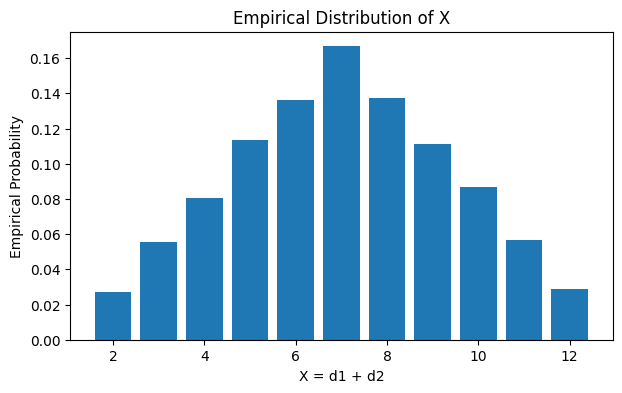

In [8]:
N = 20000
samples = [simulate_once() for _ in range(N)]

X = [d1+d2 for (d1,d2) in samples]
cnt = Counter(X)

xs = sorted(cnt.keys())
pmf_empirical = [cnt[k]/N for k in xs]

plt.figure(figsize=(7,4))
plt.bar(xs, pmf_empirical)
plt.xlabel("X = d1 + d2")
plt.ylabel("Empirical Probability")
plt.title("Empirical Distribution of X")
plt.show()


可以看到典型的“三角形”分布：中间的和值更大。

## 3.2 理论分布（通过枚举计算）

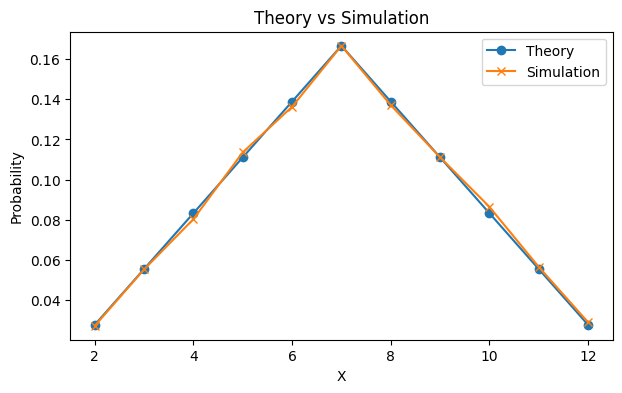

In [9]:
cnt_theory = {
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6,
    8:5,
    9:4,
    10:3,
    11:2,
    12:1
}
pmf_theory = [cnt_theory[k]/36 for k in xs]

plt.figure(figsize=(7,4))
plt.plot(xs, pmf_theory, marker='o', label="Theory")
plt.plot(xs, pmf_empirical, marker='x', label="Simulation")
plt.xlabel("X")
plt.ylabel("Probability")
plt.title("Theory vs Simulation")
plt.legend()
plt.show()


你会看到：随着样本量增大，模拟分布逼近理论概率。

---

# 4️⃣ 条件概率与乘法法则（product rule）

前 20 页提到：

$$
P(A \cap B) = P(A \mid B)\,P(B)
$$

我们用以下事件：

- $A$：两骰点数之和 $\ge 9$  
- $B$：第一枚骰子 $= 6$

---

## 4.1 用模拟估计三种概率


In [10]:
A = lambda w: (w[0] + w[1]) >= 9
B = lambda w: (w[0] == 6)

N = 20000
samples = [simulate_once() for _ in range(N)]

count_A = sum(1 for w in samples if A(w))
count_B = sum(1 for w in samples if B(w))
count_A_and_B = sum(1 for w in samples if A(w) and B(w))

P_A = count_A / N
P_B = count_B / N
P_A_and_B = count_A_and_B / N
P_A_given_B = count_A_and_B / count_B if count_B > 0 else 0

P_A, P_B, P_A_and_B, P_A_given_B


(0.2811, 0.16765, 0.1137, 0.6781986280942439)

## 4.2 检验乘法法则

In [12]:
print("LHS = P(A∩B) =", P_A_and_B)
print("RHS = P(A|B) * P(B) =", P_A_given_B * P_B)


LHS = P(A∩B) = 0.1137
RHS = P(A|B) * P(B) = 0.11369999999999998


若接近，则说明模拟验证了乘法法则。

# 5️⃣机器学习视角：学习 $p(y|x)$ 的简单演示

前 20 页讲到机器学习的本质是学习条件分布：

$$
y \sim p(y \mid x)
$$

我们构造一个非常简单的例子：

- $x = 0$ 表示“不下雨”
- $x = 1$ 表示“下雨”
- $y = 1$ 表示“带伞”

人为设定：

$$
P(y=1 \mid x=0)=0.2,\qquad P(y=1 \mid x=1)=0.9
$$


## 5.1 随机生成数据

In [13]:
def sample_xy(N=2000):
    xs = np.random.randint(0,2,size=N)
    ys = []
    for x in xs:
        if x == 0:
            ys.append(np.random.rand() < 0.2)
        else:
            ys.append(np.random.rand() < 0.9)
    return np.array(xs), np.array(ys)

xs, ys = sample_xy()

# 经验估计 p(y|x)
p_y1_x0 = ys[xs==0].mean()
p_y1_x1 = ys[xs==1].mean()
p_y1_x0, p_y1_x1



(np.float64(0.21115537848605578), np.float64(0.8945783132530121))

输出应接近什么值？

这说明：通过数据估计条件概率，就是机器学习的最基本形式。

# 🧪 贝叶斯实验：基于医疗检测数据的先验–后验分析

本实验通过一个简化的**医疗检测场景**，用 Python 完成一次完整的贝叶斯分析，重点理解：

- 先验概率（prior）
- 似然（likelihood）
- 后验概率（posterior）
- 基准率（base rate）
- 信息更新 $P(D \mid T)$
- 同一检测在不同人群中的差异

> 记号说明：  
> - $D$：是否患病（$D=1$ 患病，$D=0$ 不患病）  
> - $T$：检测结果（$T=1$ 阳性，$T=0$ 阴性）


In [14]:
# 0. 导入依赖
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 为了实验可重复
np.random.seed(42)


## 0️⃣ 生成一份“模拟真实”的医疗检测数据

我们假设**自己是上帝，主宰一切**因此可以设定：

- 总样本量 $N = 400$
- 真正的患病率（总体层面）为 $P(D=1) = 0.1$
- 检测方法的灵敏度（敏感度）为 $P(T=1 \mid D=1) = 0.9$
- 检测方法的特异度为 $P(T=0 \mid D=0) = 0.95$

生成数据步骤：

1. 按照患病率模拟每个人是否患病。  
2. 对每个个体，根据其真实病情和检测性能（灵敏度、特异度），模拟检测结果。  
3. 得到一个包含两列的数据集：
   - `disease`：0/1  
   - `test`：0/1  


In [15]:
# 1. 生成模拟数据

N = 400  # 样本量

# 真实参数（用于生成数据）
p_disease_true = 0.10      # 真正患病率 P(D=1)
sens_true = 0.90           # 灵敏度 P(T=1|D=1)
spec_true = 0.95           # 特异度 P(T=0|D=0)

# 1) 模拟是否患病
disease = (np.random.rand(N) < p_disease_true).astype(int)  # 0/1

# 2) 模拟检测结果
test = np.zeros(N, dtype=int)

for i in range(N):
    if disease[i] == 1:
        # 患病者：以灵敏度为阳性概率
        test[i] = int(np.random.rand() < sens_true)
    else:
        # 未患病者：以假阳性率(1-spec_true)为阳性概率
        test[i] = int(np.random.rand() < (1 - spec_true))

# 3) 组装成 DataFrame
df = pd.DataFrame({
    "disease": disease,
    "test": test
})

df.head(100)


,disease,test
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,1,0


## 1️⃣ 构造 $2 \times 2$ 混淆矩阵

记混淆矩阵为：

|              | $D=1$（患病） | $D=0$（不患病） |
|--------------|---------------|-----------------|
| $T=1$（阳性） |      a        |       b         |
| $T=0$（阴性） |      c        |       d         |

我们从数据中统计 $a,b,c,d$。


In [16]:
# 2. 混淆矩阵统计

# 使用 pandas crosstab
ct = pd.crosstab(df["test"], df["disease"], rownames=["T"], colnames=["D"])
ct

# 为了后续方便，取出 a,b,c,d
# 按照表格定义：
# a = T=1 且 D=1
# b = T=1 且 D=0
# c = T=0 且 D=1
# d = T=0 且 D=0

a = ct.loc[1,1]
b = ct.loc[1,0]
c = ct.loc[0,1]
d = ct.loc[0,0]

N_check = a + b + c + d

a, b, c, d, N_check



(np.int64(47), np.int64(13), np.int64(2), np.int64(338), np.int64(400))

### 1.1 用频率估计基础概率

根据混淆矩阵，估计下面这些量：

- 患病率（先验的频率估计）：
  
  $$
  \hat P(D=1) = \frac{a + c}{a + b + c + d}
  $$

- 灵敏度（敏感度）：

  $$
  \hat P(T=1 \mid D=1) = \frac{a}{a + c}
  $$

- 特异度：

  $$
  \hat P(T=0 \mid D=0) = \frac{d}{b + d}
  $$

- 假阳性率：

  $$
  \hat P(T=1 \mid D=0) = \frac{b}{b + d}
  $$

- 直接从数据估计的后验：

  $$
  \hat P(D=1 \mid T=1) = \frac{a}{a + b}
  $$


In [17]:
# 3. 频率估计

p_D1_hat = (a+c)/(a+b+c+d)          # 患病率
p_T1_given_D1_hat = a/(a+c)   # 灵敏度
p_T0_given_D0_hat = d/(b+d)   # 特异度
p_T1_given_D0_hat = b/(b+d)  # 假阳性率
p_D1_given_T1_freq = a/(a+b)  # 条件频率

p_D1_hat, p_T1_given_D1_hat, p_T0_given_D0_hat, p_T1_given_D0_hat, p_D1_given_T1_freq


(np.float64(0.1225),
 np.float64(0.9591836734693877),
 np.float64(0.9629629629629629),
 np.float64(0.037037037037037035),
 np.float64(0.7833333333333333))

可以在 Notebook 中打印并解释这些值，例如：

- $\hat P(D=1)$ 是否接近我们生成数据时设定的 $0.1$？  
- $\hat P(T=1 \mid D=1)$ 是否接近 $0.9$？  
- $\hat P(T=0 \mid D=0)$ 是否接近 $0.95$？  

这说明：**频率估计在样本量足够大时，会接近真实参数。**


In [19]:
print(f"样本估计患病率 P(D=1) ≈ {p_D1_hat:.3f}")
print(f"样本估计灵敏度 P(T=1|D=1) ≈ {p_T1_given_D1_hat:.3f}")
print(f"样本估计特异度 P(T=0|D=0) ≈ {p_T0_given_D0_hat:.3f}")
print(f"样本估计假阳性率 P(T=1|D=0) ≈ {p_T1_given_D0_hat:.3f}")
print(f"直接条件频率 P(D=1|T=1) ≈ {p_D1_given_T1_freq:.3f}")


样本估计患病率 P(D=1) ≈ 0.122
样本估计灵敏度 P(T=1|D=1) ≈ 0.959
样本估计特异度 P(T=0|D=0) ≈ 0.963
样本估计假阳性率 P(T=1|D=0) ≈ 0.037
直接条件频率 P(D=1|T=1) ≈ 0.783


## 2️⃣ 使用贝叶斯公式计算后验概率

贝叶斯公式：

$$
P(D=1 \mid T=1) = \frac{P(T=1 \mid D=1)\, P(D=1)}{P(T=1)}.
$$

其中：

- $P(D=1)$：先验  
- $P(T=1 \mid D=1)$：灵敏度  
- $P(T=1 \mid D=0)$：假阳性率  
- $P(T=1)$：边缘概率

我们先用**样本频率**作为先验和似然，然后用贝叶斯公式算一次后验，看看与“直接条件频率”有多接近。


In [20]:
# 4. 使用样本频率作为输入，做一次贝叶斯更新

# 将频率估计作为“参数”
P_D1 = p_D1_hat
P_D0 = 1 - P_D1

P_T1_given_D1 = p_T1_given_D1_hat
P_T1_given_D0 = p_T1_given_D0_hat

# 边缘概率 P(T=1)
P_T1 = P_T1_given_D1*P_D1+P_T1_given_D0*P_D0

# 贝叶斯后验 P(D=1|T=1)
P_D1_given_T1_bayes = (P_T1_given_D1*P_D1)/P_T1

P_T1, P_D1_given_T1_bayes


(np.float64(0.15), np.float64(0.7833333333333333))

对比：

- 直接条件频率（纯频率学派视角）：

  $$
  \hat P(D=1 \mid T=1) = \frac{a}{a + b}
  $$

- 贝叶斯公式（频率估计作为“参数”）得到的后验：

  $$
  P(D=1 \mid T=1)_{\text{Bayes}} = \frac{P(T=1 \mid D=1)\,P(D=1)}{P(T=1)}
  $$

在大样本下，两者应当非常接近。


In [21]:
print(f"直接条件频率 P(D=1|T=1) ≈ {p_D1_given_T1_freq:.4f}")
print(f"贝叶斯公式计算的 P(D=1|T=1) ≈ {P_D1_given_T1_bayes:.4f}")


直接条件频率 P(D=1|T=1) ≈ 0.7833
贝叶斯公式计算的 P(D=1|T=1) ≈ 0.7833


## 3️⃣ 改变先验：普通人群 vs 高危人群

现在我们不再把先验 $P(D=1)$ 固定为样本患病率，而是假设：

- 场景 A（普通人群）：$P(D=1) = 0.01$
- 场景 B（高危人群）：$P(D=1) = 0.20$

仍然使用刚才样本估计的灵敏度与假阳性率：

- $P(T=1 \mid D=1) \approx \hat P(T=1 \mid D=1)$
- $P(T=1 \mid D=0) \approx \hat P(T=1 \mid D=0)$

对于每个场景计算：

$$
P(T=1) = P(T=1 \mid D=1) P(D=1) + P(T=1 \mid D=0) P(D=0),
$$

$$
P(D=1 \mid T=1) = \frac{P(T=1 \mid D=1) P(D=1)}{P(T=1)}.
$$


In [22]:
# 5. 不同先验下的贝叶斯后验

# 使用样本估计的检测性能
P_T1_D1 = p_T1_given_D1_hat
P_T1_D0 = p_T1_given_D0_hat

def posterior_with_prior(prior_D1):
    prior_D0 = 1 - prior_D1
    P_T1 = P_T1_D1 * prior_D1 + P_T1_D0 * prior_D0
    P_D1_T1 = (P_T1_D1 * prior_D1) / P_T1
    return P_T1, P_D1_T1

# 场景 A：普通人群
prior_A = 0.01
P_T1_A, P_D1_T1_A = posterior_with_prior(prior_A)

# 场景 B：高危人群
prior_B = 0.20
P_T1_B, P_D1_T1_B = posterior_with_prior(prior_B)

P_T1_A, P_D1_T1_A, P_T1_B, P_D1_T1_B


(np.float64(0.04625850340136055),
 np.float64(0.20735294117647057),
 np.float64(0.2214663643235072),
 np.float64(0.8662116040955631))

打印结果，并比较两个场景下 $P(D=1 \mid T=1)$ 的区别。


In [23]:
print("=== 场景 A：普通人群（先验 P(D=1)=0.01） ===")
print(f"P(T=1) ≈ {P_T1_A:.4f}")
print(f"P(D=1|T=1) ≈ {P_D1_T1_A:.4f}")

print("\n=== 场景 B：高危人群（先验 P(D=1)=0.20） ===")
print(f"P(T=1) ≈ {P_T1_B:.4f}")
print(f"P(D=1|T=1) ≈ {P_D1_T1_B:.4f}")


=== 场景 A：普通人群（先验 P(D=1)=0.01） ===
P(T=1) ≈ 0.0463
P(D=1|T=1) ≈ 0.2074

=== 场景 B：高危人群（先验 P(D=1)=0.20） ===
P(T=1) ≈ 0.2215
P(D=1|T=1) ≈ 0.8662


### 小结

- 同样的检测性能（灵敏度、特异度），在不同人群（先验不同）下，  
  同样是阳性结果 $T=1$，后验 $P(D=1 \mid T=1)$ 可以相差很大。

- 这对应课堂上讲的“基准率”效应：  
  若忽略总体患病率（先验），只看到“检测很准”，容易高估阳性结果代表的“真的得病”的概率。

---

